In [1]:
import os
import random
import warnings
from collections import defaultdict
from glob import glob
from pprint import pprint

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.layers import (GRU, LSTM, AveragePooling2D, Conv2D,
                                     Dense, Flatten, Input, MaxPooling2D,
                                     Permute, Reshape)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tqdm import tqdm

/home/adimyth/.cache/pypoetry/virtualenvs/arya-date-FMMjjJ2d-py3.7/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
TEST_IMAGES_PATH = '../data/processed/test/'
TRAIN_CSV_PATH = '../data/raw/train/corrected_train_data.csv'
TRAIN_IMAGES_PATH = '../data/processed/train/'
RANDOM_STATE = 42

In [3]:
PUBLIC_host = 'http://13.234.225.243'
SUBMISSION_URL = PUBLIC_host + ':8080/submit'
LEADERBOARD_URL = PUBLIC_host + ':8080/leaderboard'
DATA_URL = PUBLIC_host + ':9600'

In [4]:
date_range = (0, 8)
image_inp_shape = (100, 450, 1)
tag = "deepak_starter_notebook_v5"

In [5]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"


seed_everything(RANDOM_STATE)

In [6]:
train_df = pd.read_csv(TRAIN_CSV_PATH, dtype=str)

In [7]:
def model(inp_shape=(100, 450, 1), num_outs=8):
    inp = Input(shape=inp_shape)

    c = Conv2D(8, (3, 3), activation="relu")(inp)
    # c = MaxPooling2D((2,3))(c)
    c = AveragePooling2D((2, 3))(c)

    c = Conv2D(1, (3, 3), activation="relu")(c)
    # c = MaxPooling2D((2,3))(c)
    c = AveragePooling2D((2, 3))(c)

    r = Reshape((int(c.shape[1]), int(c.shape[2])))(c)
    p = Permute((2, 1))(r)

    shared_softmax = Dense(10, activation="softmax")

    outs = []
    for xx in range(num_outs):
        l = LSTM(20, return_sequences=True)(p)
        f = Flatten()(l)
        s = shared_softmax(f)
        outs.append(s)
    if num_outs == 1:
        outs = outs[0]
    model = Model(inputs=inp, outputs=outs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return model

In [8]:
def generator(
    batch_size=32,
    image_inp_shape=(450, 100),
    rand_flag=True,
    mode="train",
    train_ratio=0.8,
    date_range=(0, 7),
):
    images_files = glob(TRAIN_IMAGES_PATH + "/*.png")
    train_size = int(len(images_files) * train_ratio)
    images_files = (
        images_files[:train_size] if mode == "train" else images_files[train_size:]
    )
    iter_count = 0
    while True:
        try:
            if rand_flag:
                x_batch = random.sample(images_files, batch_size)
            else:
                x_batch = images_files[
                    iter_count * batch_size : iter_count * batch_size + batch_size
                ]
            iter_count += 1
            y_batch = list(
                map(
                    lambda x: train_df.loc[
                        train_df["tag"] == x.split("/")[-1].split(".")[0]
                    ]["label"].item().zfill(8),
                    x_batch,
                )
            )
            x_batch = np.array(
                list(
                    map(
                        lambda x: np.expand_dims(
                            cv2.resize(cv2.imread(x, 0), (image_inp_shape)), -1
                        ),
                        x_batch,
                    )
                )
            )
            y_batch = np.eye(10)[
                list(
                    map(
                        lambda x: list(
                            map(
                                lambda xx: int(xx),
                                list(x)[date_range[0] : date_range[1]],
                            )
                        ),
                        y_batch,
                    )
                )
            ]
            y_batch = list(np.swapaxes(y_batch, 0, 1))

            if date_range[1] - date_range[0] == 1:
                y_batch = y_batch[0]

            yield (x_batch, y_batch)
        except Exception as e:
            print(e)
            continue

In [9]:
m = model(inp_shape=image_inp_shape, num_outs=date_range[1] - date_range[0])

In [10]:
m.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 450, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 98, 448, 8)   80          input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 49, 149, 8)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 47, 147, 1)   73          average_pooling2d[0][0]          
_______________________________________________________________________________________

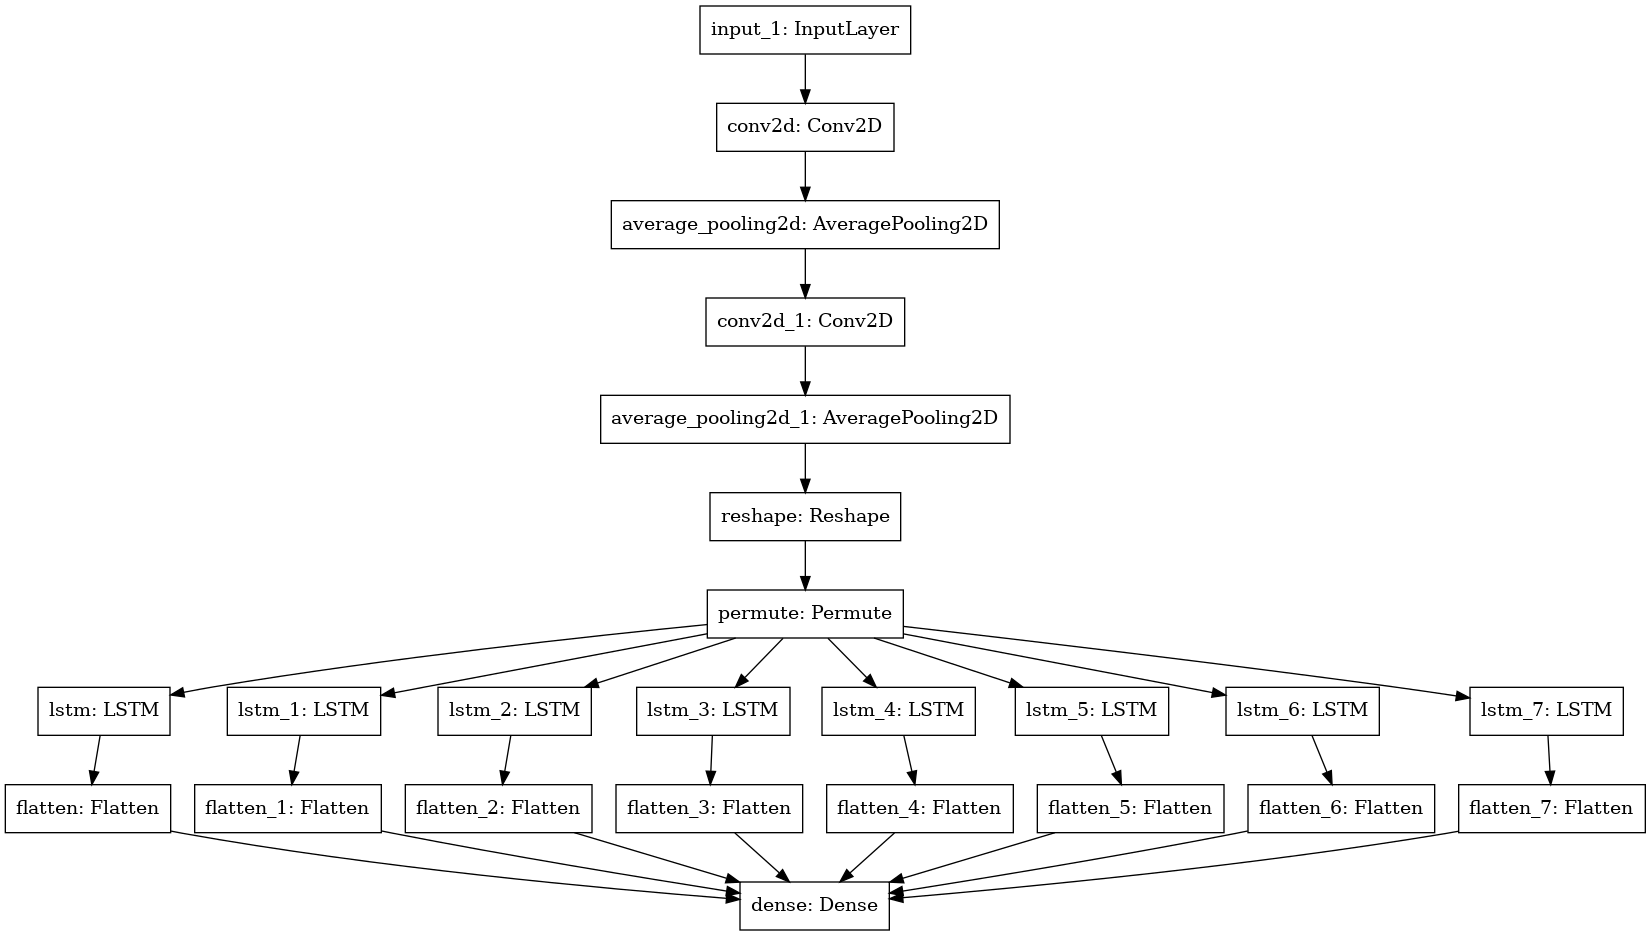

In [11]:
plot_model(m)

In [12]:
model_file_path = f"../models/{tag}_{date_range[0]}-{date_range[1]}.h5"

# callbacks
cbk = ModelCheckpoint(
    model_file_path, monitor="val_loss", save_weights_only=False, save_best_only=True
)
log = CSVLogger(f"../logs/{tag}.log")

# training
m.fit(
    generator(image_inp_shape=(450, 100), date_range=date_range),
    epochs=3,
    steps_per_epoch=300,
    validation_data=generator(
        image_inp_shape=(450, 100), rand_flag=True, mode="val", date_range=date_range
    ),
    validation_steps=100,
    callbacks=[cbk, log],
)

Epoch 1/3
300/300 [==============================] - 190s 633ms/step - loss: 12.5460 - dense_loss: 2.3370 - dense_1_loss: 2.3431 - dense_2_loss: 2.3346 - dense_3_loss: 2.3222 - dense_4_loss: 1.6572 - dense_5_loss: 0.7590 - dense_6_loss: 0.7697 - dense_7_loss: 0.0232 - dense_accuracy: 0.1133 - dense_1_accuracy: 0.1177 - dense_2_accuracy: 0.1190 - dense_3_accuracy: 0.1147 - dense_4_accuracy: 0.2272 - dense_5_accuracy: 0.5754 - dense_6_accuracy: 0.5806 - dense_7_accuracy: 0.9955 - val_loss: 12.0390 - val_dense_loss: 2.3073 - val_dense_1_loss: 2.3366 - val_dense_2_loss: 2.3014 - val_dense_3_loss: 2.2914 - val_dense_4_loss: 1.6245 - val_dense_5_loss: 0.6097 - val_dense_6_loss: 0.5665 - val_dense_7_loss: 0.0016 - val_dense_accuracy: 0.1244 - val_dense_1_accuracy: 0.1128 - val_dense_2_accuracy: 0.1381 - val_dense_3_accuracy: 0.1172 - val_dense_4_accuracy: 0.2444 - val_dense_5_accuracy: 0.7006 - val_dense_6_accuracy: 0.7434 - val_dense_7_accuracy: 1.0000
Epoch 2/3
300/300 [====================

In [13]:
# m = load_model(model_file_path)
images_files = glob(TEST_IMAGES_PATH + "/*.png")

s_dict = defaultdict(list)
for image_file in tqdm(images_files):
    x_test = np.expand_dims(cv2.resize(cv2.imread(image_file, 0), (450, 100)), -1)
    pred = m.predict(np.array([x_test]))
    pred_label = "".join(list(map(lambda x: str(np.argmax(x)), pred)))
    s_dict["tag"].append(image_file.split("/")[-1].split(".")[0])
    s_dict["label"].append(pred_label)

sub_df = pd.DataFrame(s_dict)

100%|██████████| 1000/1000 [01:23<00:00, 11.98it/s]


In [14]:
sub_df["tag"] = sub_df["tag"].astype("int")
sub_df = sub_df.sort_values(by="tag")

In [15]:
sub_df[10:20].head()

,tag,label
777,10,65773781
456,11,65414871
701,12,75842881
873,13,95992781
274,14,30034771


In [16]:
def plot_grid(files, labels=None, h=6, w=6, title=""):
    f, ax = plt.subplots(h, w, figsize=(18, 18))
    for idx, path in enumerate(random.choices(files, k=h*w)):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, 3)
        image = tf.cast(image/255, tf.float32)
        image_number = path.split("/")[-1].split(".")[0]
        label = labels.loc[labels["tag"]==int(image_number)]["label"].values[0]

        ax[idx // h, idx % w].imshow(image)
        ax[idx // h, idx % w].axis("off")
        ax[idx // h, idx % w].set_title(f"Image: {image_number} Label: {label}")
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

In [18]:
test_files = glob(os.path.join("../data/processed/test", "*.png"))

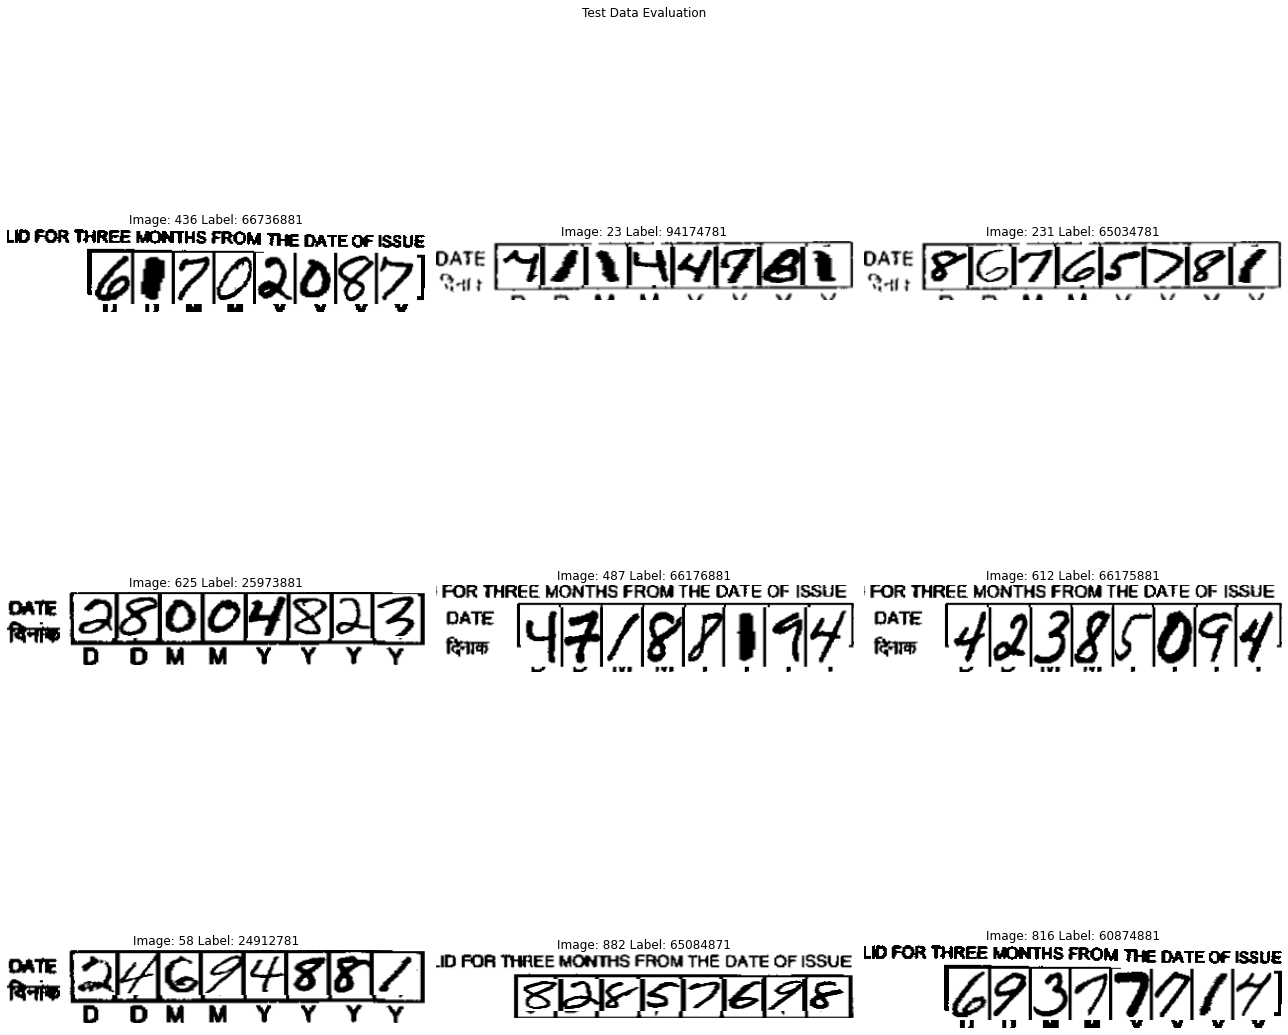

In [49]:
plot_grid(test_files, sub_df, h=3, w=3, title="Test Data Evaluation")

In [22]:
processed_test_files = glob(os.path.join("../data/interim/test", "*.png"))

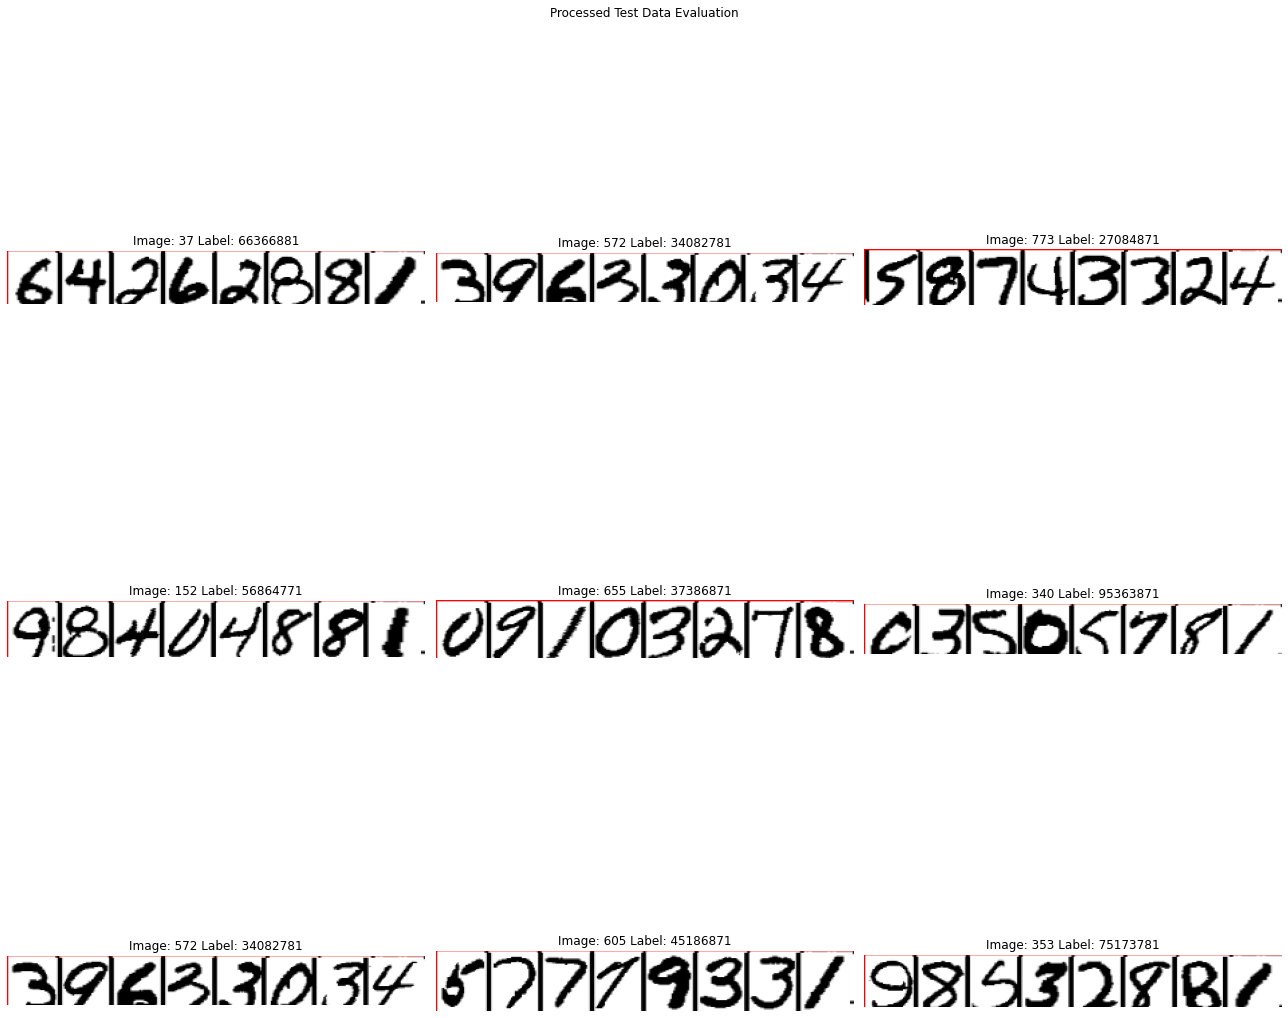

In [50]:
plot_grid(processed_test_files, sub_df, h=3, w=3, title="Processed Test Data Evaluation")

In [24]:
sub_df.to_csv(f"../submissions/{tag}.csv", index=False)

In [25]:
sub_json = sub_df.to_json()
data = {
    "username": "deepak",
    "password": "xxxx",
    "submission": sub_json,
    "tag": tag,
}
# r = requests.post(SUBMISSION_URL, json=data)

In [26]:
# r.text

In [27]:
rl = requests.post(LEADERBOARD_URL, json={})
pprint(rl.json())

{'leaderboard': [{'score': 0.0,
                  'submitted_at': '2020-10-24-06-36-1603521407',
                  'tag': 'test2',
                  'username': 'deepak'}],
 'success': True}


**Comparing different versions**

In [28]:
!ls ../logs

deepak_starter_notebook_v4.log	deepak_starter_notebook_v5.log


In [29]:
v1 = pd.read_csv("../logs/deepak_starter_notebook_v4.log")
v2 = pd.read_csv("../logs/deepak_starter_notebook_v5.log")

In [30]:
loss_cols, acc_cols, val_loss, val_acc = [], [], [], []

In [31]:
for col in v1.columns:
    if "accuracy" in col and "val" in col:
        val_acc.append(col)
    elif "loss" in col and "val" in col:
        val_loss.append(col)
    elif "accuracy" in col:
        acc_cols.append(col)
    else:
        loss_cols.append(col)

In [32]:
v1[acc_cols]

,dense_1_accuracy,dense_2_accuracy,dense_3_accuracy,dense_4_accuracy,dense_5_accuracy,dense_6_accuracy,dense_7_accuracy,dense_accuracy
0,0.116667,0.118750,0.102812,0.231771,0.534792,0.546042,0.995625,0.116042
1,0.121458,0.146875,0.108854,0.287500,0.694271,0.718333,1.000000,0.120208
2,0.154375,0.167396,0.130313,0.355729,0.787396,0.779271,1.000000,0.147813


In [34]:
v2[acc_cols]

,dense_1_accuracy,dense_2_accuracy,dense_3_accuracy,dense_4_accuracy,dense_5_accuracy,dense_6_accuracy,dense_7_accuracy,dense_accuracy
0,0.117708,0.118958,0.114688,0.227187,0.575417,0.580625,0.995521,0.113333
1,0.127188,0.168229,0.143750,0.308542,0.781250,0.766563,1.000000,0.158333
2,0.156354,0.214375,0.199583,0.439792,0.850104,0.818854,1.000000,0.225625


*Mean Accuracy Improvement per Layer*

In [35]:
inter = v2[acc_cols]-v1[acc_cols]
inter.mean()

dense_1_accuracy    0.002917
dense_2_accuracy    0.022847
dense_3_accuracy    0.038681
dense_4_accuracy    0.033507
dense_5_accuracy    0.063438
dense_6_accuracy    0.040799
dense_7_accuracy   -0.000035
dense_accuracy      0.037743
dtype: float64

In [36]:
print(f"Total Improvement: {inter.mean().mean():.4}")

Total Improvement: 0.02999


In [37]:
v1[val_acc]

,val_dense_1_accuracy,val_dense_2_accuracy,val_dense_3_accuracy,val_dense_4_accuracy,val_dense_5_accuracy,val_dense_6_accuracy,val_dense_7_accuracy,val_dense_accuracy
0,0.120625,0.116250,0.113438,0.222500,0.568438,0.65500,1.0,0.124688
1,0.130625,0.135000,0.104687,0.310625,0.760312,0.74375,1.0,0.115938
2,0.178125,0.164687,0.117188,0.390000,0.829687,0.81125,1.0,0.156250


In [38]:
v2[val_acc]

,val_dense_1_accuracy,val_dense_2_accuracy,val_dense_3_accuracy,val_dense_4_accuracy,val_dense_5_accuracy,val_dense_6_accuracy,val_dense_7_accuracy,val_dense_accuracy
0,0.112812,0.138125,0.117188,0.244375,0.700625,0.743438,1.0,0.124375
1,0.135312,0.192813,0.147188,0.375000,0.835000,0.771875,1.0,0.179063
2,0.173125,0.208438,0.226875,0.483750,0.878438,0.847188,1.0,0.237188


*Mean Accuracy Improvement per Layer*

In [39]:
inter = v2[val_acc]-v1[val_acc]
inter.mean()

val_dense_1_accuracy   -0.002708
val_dense_2_accuracy    0.041146
val_dense_3_accuracy    0.051979
val_dense_4_accuracy    0.060000
val_dense_5_accuracy    0.085208
val_dense_6_accuracy    0.050833
val_dense_7_accuracy    0.000000
val_dense_accuracy      0.047917
dtype: float64

In [40]:
print(f"Total Improvement: {inter.mean().mean():.4}")

Total Improvement: 0.0418


In [41]:
v1[loss_cols]

,epoch,dense_1_loss,dense_2_loss,dense_3_loss,dense_4_loss,dense_5_loss,dense_6_loss,dense_7_loss,dense_loss,loss
0,0,2.332853,2.332899,2.345359,1.650126,0.778503,0.797140,0.023301,2.339688,12.599868
1,1,2.305687,2.276895,2.314586,1.571141,0.594007,0.578361,0.000622,2.305250,11.946549
2,2,2.263404,2.244451,2.298508,1.496235,0.483826,0.498117,0.000345,2.272978,11.557858


In [42]:
v2[loss_cols]

,epoch,dense_1_loss,dense_2_loss,dense_3_loss,dense_4_loss,dense_5_loss,dense_6_loss,dense_7_loss,dense_loss,loss
0,0,2.343082,2.334564,2.322152,1.657221,0.759011,0.769704,0.023229,2.337035,12.545997
1,1,2.318482,2.248929,2.267480,1.545802,0.515980,0.519555,0.001328,2.253699,11.671250
2,2,2.282491,2.163422,2.189861,1.400282,0.392342,0.425371,0.000927,2.148157,11.002851


*Mean Loss Decrease per Layer*

In [43]:
inter = v2[loss_cols]-v1[loss_cols]
inter.mean()

epoch           0.000000
dense_1_loss    0.014036
dense_2_loss   -0.035777
dense_3_loss   -0.059653
dense_4_loss   -0.038066
dense_5_loss   -0.063001
dense_6_loss   -0.052996
dense_7_loss    0.000405
dense_loss     -0.059675
loss           -0.294726
dtype: float64

In [44]:
print(f"Total Loss Decrease: {inter.mean().mean():.4}")

Total Loss Decrease: -0.05895


In [45]:
v1[val_loss]

,val_dense_1_loss,val_dense_2_loss,val_dense_3_loss,val_dense_4_loss,val_dense_5_loss,val_dense_6_loss,val_dense_7_loss,val_dense_loss,val_loss
0,2.322343,2.312643,2.309429,1.638951,0.662055,0.632702,0.000814,2.324605,12.203543
1,2.304349,2.279617,2.309250,1.552584,0.540794,0.536700,0.000559,2.317857,11.841709
2,2.226177,2.241724,2.318818,1.454755,0.427919,0.458808,0.000242,2.268129,11.396570


In [46]:
v2[val_loss]

,val_dense_1_loss,val_dense_2_loss,val_dense_3_loss,val_dense_4_loss,val_dense_5_loss,val_dense_6_loss,val_dense_7_loss,val_dense_loss,val_loss
0,2.336574,2.301403,2.291373,1.624469,0.609726,0.566480,0.001603,2.307344,12.038972
1,2.310505,2.206187,2.254262,1.500442,0.448720,0.513825,0.001312,2.237198,11.472448
2,2.271751,2.163854,2.168980,1.353346,0.349878,0.364441,0.000802,2.121940,10.794989


*Mean Loss Decrease per Layer*

In [47]:
inter = v2[val_loss]-v1[val_loss]
inter.mean()

val_dense_1_loss    0.021987
val_dense_2_loss   -0.054180
val_dense_3_loss   -0.074294
val_dense_4_loss   -0.056011
val_dense_5_loss   -0.074148
val_dense_6_loss   -0.061154
val_dense_7_loss    0.000701
val_dense_loss     -0.081370
val_loss           -0.378471
dtype: float64

In [48]:
print(f"Total Loss Decrease: {inter.mean().mean():.4}")

Total Loss Decrease: -0.0841


Following works -
* Trimming whitespaces
* Crop images if date-field could be properly detected (using heuristics)
* Padding initial zeros for cases where length < 8